Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `last_inspection_end_date = case_when(...)`.
Caused by warning in `as.Date()`:
! NAs introduced by coercion"


Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2021-04-02" "2024-08-15" "2024-10-27" "2024-09-24" "2025-01-16" "2025-03-13" 
        NA's 
        "18"

[1] "C:/Users/dell/data screening"

name,city,state,level_a,level_b,level_c,level_d,last_inspection_end_date,num_level_a,num_level_b,num_level_c,num_level_d,total_population,Total_Population
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADAMS COUNTY DET CENTER,NATCHEZ,MS,1876.4610780,266.4311377,6.7245509,4.2574850,2025-01-16,1876.4610780,266.4311377,6.7245509,4.2574850,2153.874252,2153.874252
ADELANTO ICE PROCESSING CENTER,ADELANTO,CA,6.4011976,4.3233533,22.6047904,32.6347305,2024-07-18,6.4011976,4.3233533,22.6047904,32.6347305,65.964072,65.964072
ALAMANCE COUNTY DETENTION FACILITY,GRAHAM,NC,4.3293413,3.4610778,6.0838323,6.1856287,2024-09-19,4.3293413,3.4610778,6.0838323,6.1856287,20.059880,20.059880
ALEXANDRIA STAGING FACILITY,ALEXANDRIA,LA,137.5209581,47.4131736,76.0059880,52.4850299,2024-08-29,137.5209581,47.4131736,76.0059880,52.4850299,313.425150,313.425150
ALLEGANY COUNTY JAIL,BELMONT,NY,1.2215569,0.0180000,0.0000000,0.0000000,NA,1.2215569,0.0180000,0.0000000,0.0000000,1.239557,1.239557
ALLEN PARISH PUBLIC SAFETY COMPLEX,OBERLIN,LA,101.3113772,30.2514970,33.7664671,10.6646707,2024-12-12,101.3113772,30.2514970,33.7664671,10.6646707,175.994012,175.994012
ATLANTAUSPEN,ATLANTA,,17.3413174,3.6107784,3.0538922,2.7245509,NA,17.3413174,3.6107784,3.0538922,2.7245509,26.730539,26.730539
BAKER COUNTY SHERIFF DEPT,MACCLENNY,FL,26.2215569,38.6407186,88.6526946,88.7305389,2024-10-24,26.2215569,38.6407186,88.6526946,88.7305389,242.245509,242.245509
BERLIN FED CORR INST,BERLIN,NH,1.7485030,0.0898000,0.9700599,0.7125748,NA,1.7485030,0.0898000,0.9700599,0.7125748,3.520938,3.520938


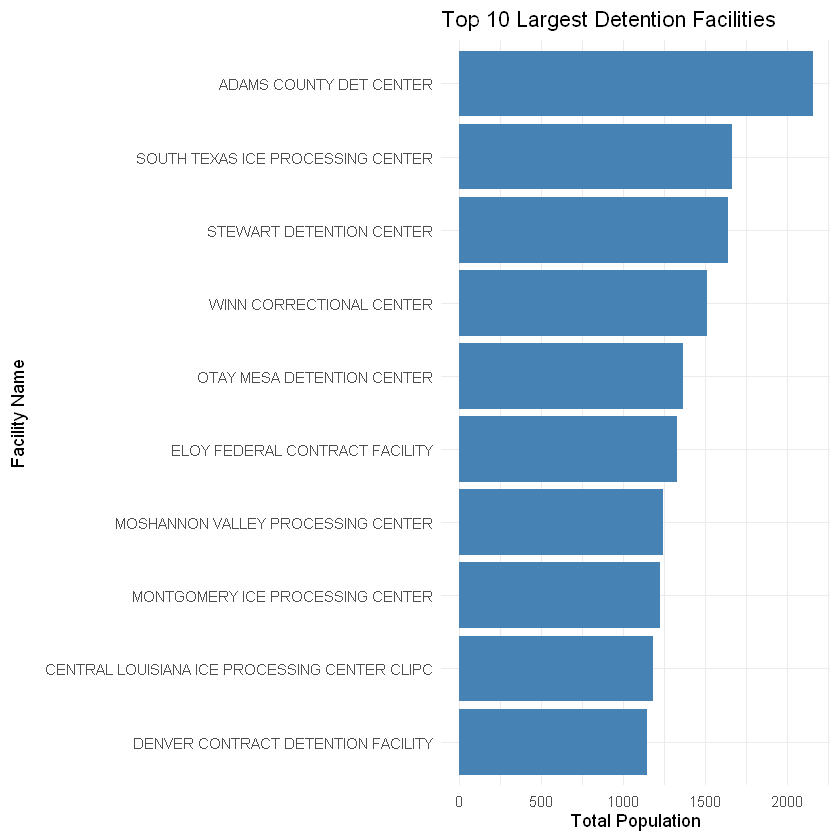

In [12]:
# Load necessary libraries
library(tidyverse)
library(readr)
library(lubridate)
library(dplyr)
library(janitor)
library(stringr)
library(ggplot2)

# Load the data
rm(data)  # Clear existing data from environment
data <- read.csv("messy_ice_detention.csv", stringsAsFactors = FALSE)

# Clean column names to snake_case
colnames(data) <- janitor::make_clean_names(colnames(data))

# Clean up facility names (name column)
data$name <- data$name %>%
  str_replace_all("[$%&@*^#()\\[\\]{}+|<>~]", "") %>%
  str_replace_all("[[:punct:]]", "") %>%
  str_replace_all("[^[:alnum:] ]", "") %>%
  str_replace_all("\\s+", " ") %>%
  str_squish()

# Additional cleanup of special characters
data$name <- data$name %>%
  str_replace_all("[^[:alnum:]&/,. -]", "") %>%
  str_replace_all("\\s+", " ") %>%
  str_squish()

# Fixing known typos in names
data$name <- str_replace_all(data$name, c(
  "ALEXASNDRIA" = "ALEXANDRIA",
  "ALLLEN" = "ALLEN",
  "CUMBAERLAND" = "CUMBERLAND",
  "FOLKSTOAN" = "FOLKSTON",
  "CONTARACT" = "CONTRACT",
  "LOUISIANLA" = "LOUISIANA",
  "STE GENEVIEVE COUNTY SHERIFFJAIL" = "STE GENEVIEVE COUNTY SHERIFF JAIL"
))

#Manual Data Correction: DOVER and ELK RIVER (detail of this answer in README.md file)
data$name[is.na(data$name) & data$city == "DOVER"] <- "DOVER ICE FIELD OFFICE"
data$name[is.na(data$name) & data$city == "ELK RIVER"] <- "SHERBURNE COUNTY JAIL"

# Remove rows with missing name values
data <- data %>% filter(!is.na(name))

# Convert population columns to numeric and calculate total population
data <- data %>%
  mutate(across(starts_with("level"),
                ~ as.numeric(gsub("[^0-9.]", "", .)),
                .names = "num_{.col}")) %>%
  mutate(total_population = rowSums(select(., starts_with("num_level")), na.rm = TRUE))

# Convert Excel-style serial dates to real dates
data <- data %>%
  mutate(
    last_inspection_end_date = case_when(
      grepl("^[0-9]+$", as.character(last_inspection_end_date)) ~ 
        as.Date(as.numeric(as.character(last_inspection_end_date)), origin = "1899-12-30"),
      last_inspection_end_date %in% c("NA", "N/A", NA) ~ NA_Date_,
      TRUE ~ NA_Date_
    )
  )

# Leave NA values in date column for transparency and honest reporting
summary(data$last_inspection_end_date)

# Recalculate total population (in case level naming changed)
data <- data %>%
  mutate(across(starts_with("level"), ~as.numeric(.), .names = "num_{.col}"),
         Total_Population = rowSums(select(., starts_with("num_Level")), na.rm = TRUE))

# Get top 10 facilities by total population
top_10 <- data %>%
  arrange(desc(Total_Population)) %>%
  slice_head(n = 10)

# Plot the top 10 facilities
plot <- ggplot(top_10, aes(x = reorder(name, Total_Population), y = Total_Population)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Top 10 Largest Detention Facilities",
    x = "Facility Name",
    y = "Total Population"
  ) +
  theme_minimal()

# Print the plot
print(plot)

# Save the plot to working directory (optional, uncomment to use)

ggsave("top_10_detention_facilities.png", plot, width = 10, height = 6)

# Show working directory
getwd()

# Save cleaned dataset
write.csv(data, "cleaned_ice_detention_data.csv", row.names = FALSE)

# View the cleaned dataset
View(data)